In [1]:
import pygame
from ElementsNavigation.Config import Config
from Ingame.Vaisseau import Vaisseau
from Ingame.ListBullet import ListBullet
import time
import abc
from tf_agents.environments import py_environment
from tf_agents.specs import array_spec
from tf_agents.specs import tensor_spec
from tf_agents.trajectories import time_step as ts 
import numpy as np
from ElementsNavigation.Config import Config
from Ingame.ListEnnemi import ListEnnemi
from Extra.Sound import Sound
from Extra.Hud import Hud
from Ingame.AnimationInvincible import AnimationInvincible
from ElementsNavigation.GameOverEnv import GameOverEnv
import math


from Ingame.ListMeteorite import ListMeteorite
from Ingame.Meteorite import Meteorite
from Ingame.Bullet import Bullet
from Ingame.Ennemi import Ennemi

class PyEnvironment(object):

    def reset(self):
        """Return initial_time_step."""
        self._current_time_step = self._reset()
        return self._current_time_step

    def step(self, action):
        """Apply action and return new time_step."""
        if self._current_time_step is None:
            return self.reset()
        self._current_time_step = self._step(action)
        return self._current_time_step

    def current_time_step(self):
        return self._current_time_step

    def time_step_spec(self):
        """Return time_step_spec."""

    @abc.abstractmethod
    def observation_spec(self):
        """Return observation_spec."""

    @abc.abstractmethod
    def action_spec(self):
        """Return action_spec."""

    @abc.abstractmethod
    def _reset(self):
        """Return initial_time_step."""

    @abc.abstractmethod
    def _step(self, action):
        """Apply action and return new time_step."""

class Environnement(py_environment.PyEnvironment):
    def __init__(self) :
        self.config = Config()
        self._action_spec = array_spec.BoundedArraySpec(shape=(), dtype=np.int32, minimum=0, maximum=5, name='action')
        minObser = np.zeros(self.config.surfaceW * self.config.surfaceH)
        maxObser = np.ones(self.config.surfaceW * self.config.surfaceH)
        self._observation_spec = array_spec.BoundedArraySpec(shape=(self.config.surfaceW * self.config.surfaceH,), dtype=np.int32, minimum=minObser, maximum=maxObser, name='observation')
        self._episode_ended = False
        #self.listBullet = ListBullet(self.config)
        self.WINDOW          = pygame.display.set_mode((1920, 1080), flags=pygame.HIDDEN)
        self._reset()
        self.WINDOW  = None
        self.game_over      = False
        self.imgMeteorite = self.loadImg(self.MeteoriteInit.getImg())
        self.imgBullet = [self.loadImg(self.BulletInit.getImgType(0)),self.loadImg(self.BulletInit.getImgType(1))]
        self.imgFond = self.loadImg("images/fond.png")
        self.WINDOW          = pygame.display.set_mode((1920, 1080), flags=pygame.HIDDEN)
        
        

        
        self.imgVaisseau = []
        self.imgEnnemi = []
        for i in range(8):
            imgV = self.loadImg(self.vaisseauInit.getImgDirection(i))
            imgE = self.loadImg(self.EnnemiInit.getImgDirection(i))
            self.imgVaisseau.append(imgV)
            self.imgEnnemi.append(imgE)
        #self.listEnnemi = ListEnnemi(self.config,self.listBullet, self.vaisseau,self.listBullet,jeu,self.sound)
        #self.listMeteorite = ListMeteorite(self.config,self.listBullet,self.listEnnemi,self.sound,jeu,self.vaisseau)

    def loadImg(self,name):
        return pygame.image.load(name)  

    def render(self):
        WINDOW = pygame.display.set_mode((self.config.surfaceH, self.config.surfaceW))
        self.Vaisseau.update()

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def parcour_ecran(self):
        tab = []
       # for h in range(self.config.surfaceH):
       #     for w in range(self.config.surfaceW):
       #         if(w >= self.Vaisseau.x and h <= self.Vaisseau.larg and h >= self.Vaisseau.y and h <= self.Vaisseau.haut):
       #             tab.append(1)
       #             print("oui")
       #         else:
       #             tab.append(0)
       #             print([h,w])
        return tab

    def update(self):
        pygame.display.update()
        
    def _reset(self):
        self._episode_ended = False
        self.game_over      = False
        self.listBullet = ListBullet(self.config)
        self.Vaisseau = Vaisseau(self.config,self.listBullet)
        self.listEnnemi = ListEnnemi(self.config,self.listBullet, self.Vaisseau,self.listBullet,self.WINDOW,None)
        self.listMeteorite = ListMeteorite(self.config,self.listBullet,self.listEnnemi,None,self.WINDOW,self.Vaisseau)
        
        self.vaisseauInit = Vaisseau(self.config,[])
        self.BulletInit = Bullet(self.config)
        self.EnnemiInit = Ennemi(self.config,[])
        self.MeteoriteInit = Meteorite(self.config)
        self._state = self.parcour_ecran()
        return ts.restart(np.array(self._state, dtype=np.int32))
    
    def close(self):
        pygame.quit()

    def position(self,img,x,y):
        self.WINDOW.blit(img,(x,y))

    def print_screen(self):
        print("++++")
        print(self.listBullet.getListB())
        print("----")
        #self.position(self.imgFond,0,0)
        pygame.display.update()
        return pygame.surfarray.pixels3d(self.WINDOW)/255.

    def _step(self,action):
        self.WINDOW.fill((255,255,255))
        reward = 0
        xa_mvt = 0
        ya_mvt = 0
        xb_mvt = 0
        yb_mvt = 0
        da=0
        db=0
        dc=0
        dd=0
        tir = False
        if self._episode_ended:
            # The last action ended the episode. Ignore the current action and start
            # a new episode.
            return self.reset()

        if action == 1:
            ya_mvt = -self.Vaisseau.getMouvementSpeed()
            da = 1

        if action == 2:
            yb_mvt = self.Vaisseau.getMouvementSpeed()
            db = 1
            

        if action == 3:
            xa_mvt = -self.Vaisseau.getMouvementSpeed()
            dc = 1
            

        if action == 4:
            xb_mvt = self.Vaisseau.getMouvementSpeed()
            dd = 1
            

        if action == 0:
            tir = True

        self.Vaisseau.setDirection(da,db,dc,dd)
            
        if((xa_mvt+xb_mvt) != 0 and (ya_mvt+yb_mvt) !=0):
            self.Vaisseau.setx((xa_mvt+xb_mvt)*math.sqrt(0.5))
            self.Vaisseau.sety((ya_mvt+yb_mvt)*math.sqrt(0.5))
        else:
            self.Vaisseau.setx(xa_mvt+xb_mvt)
            self.Vaisseau.sety(ya_mvt+yb_mvt)
        self.Vaisseau.update()
        
        if tir:
            self.Vaisseau.tirer()
            tir = False
        
        self.listBullet.update()
        for elem in self.listBullet.getListB():
            self.position(self.imgBullet[elem.getType()],self.listBullet.getxElemListB(elem),self.listBullet.getyElemListB(elem)) 
        
        ###### ajout un enemey
        self.listEnnemi.addElemListE()

        self.listBullet = self.listEnnemi.update()
        for elem in self.listEnnemi.getListE():
            self.position(self.imgEnnemi[elem.getDirection()],self.listEnnemi.getxElemListE(elem),self.listEnnemi.getyElemListE(elem))
            #self.position(self.loadImg(self.listEnnemi.getImgElemListE(elem)),self.listEnnemi.getxElemListE(elem),self.listEnnemi.getyElemListE(elem)) 

        #######

        ###### ajout une meteorite
        self.listMeteorite.addElemListM()

        self.listMeteorite.update()
        for elem in self.listMeteorite.getListM():
            self.position(self.imgMeteorite,self.listMeteorite.getxElemListM(elem),self.listMeteorite.getyElemListM(elem)) 

        #######
        
        
        self.position(self.imgVaisseau[self.Vaisseau.getDirection()],self.Vaisseau.getx(),self.Vaisseau.gety())
        self.update()
        self._state = self.parcour_ecran()
        return ts.transition(np.array(self._state, dtype=np.int32), reward=0.0, discount=1.0)
    

pygame 2.1.0 (SDL 2.0.16, Python 3.10.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
ennv = Environnement()

In [3]:
ennv.config.getSurfaceW()

1920

++++
[]
----
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
++++
[]
----


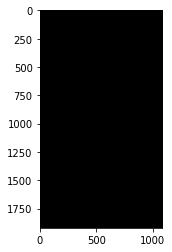

In [4]:
#env = Environnement()
#env.reset()
#print(env)
#env.step(0)
#env.render()
#env.close()

import tf_agents.environments as tt
env = Environnement()
#tt.validate_py_environment(env, episodes=5)
#print(env.reset())
print(env.print_screen())
                
import matplotlib.pyplot as plt    
plt.imshow(env.print_screen())

++++
[]
----


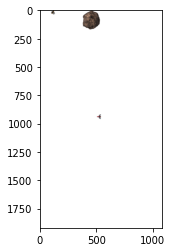

++++
[]
----


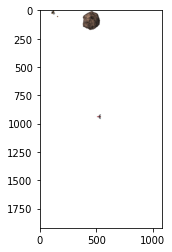

++++
[]
----


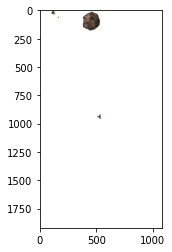

++++
[]
----


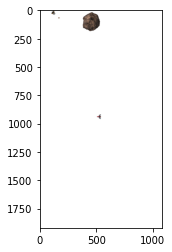

[<Ingame.Bullet.Bullet object at 0x000001A2774CFB50>, <Ingame.Bullet.Bullet object at 0x000001A205056080>]
++++
[]
----


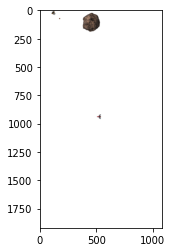

[<Ingame.Bullet.Bullet object at 0x000001A2774CFB50>, <Ingame.Bullet.Bullet object at 0x000001A205056080>]
++++
[]
----


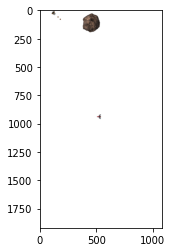

[<Ingame.Bullet.Bullet object at 0x000001A2774CFB50>, <Ingame.Bullet.Bullet object at 0x000001A205056080>]
++++
[]
----


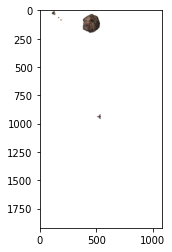

[<Ingame.Bullet.Bullet object at 0x000001A2774CFB50>, <Ingame.Bullet.Bullet object at 0x000001A205056080>]
++++
[]
----


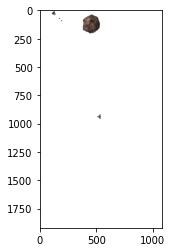

[<Ingame.Bullet.Bullet object at 0x000001A2774CFB50>, <Ingame.Bullet.Bullet object at 0x000001A205056080>, <Ingame.Bullet.Bullet object at 0x000001A205144610>]
++++
[]
----


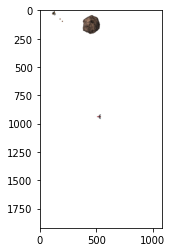

[<Ingame.Bullet.Bullet object at 0x000001A2774CFB50>, <Ingame.Bullet.Bullet object at 0x000001A205056080>, <Ingame.Bullet.Bullet object at 0x000001A205144610>]
++++
[]
----


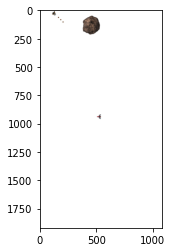

In [5]:
environment = Environnement()
action = 5
time_step = environment.reset()
#while not time_step.is_last():
for i in range(10):
    time_step = environment.step(action)
    plt.imshow(env.print_screen())
    plt.show()

In [6]:
import PIL 

In [7]:
import matplotlib

matplotlib.image.imsave('name.png', env.print_screen())

++++
[]
----
